In [1]:
import glob
import uproot as up
import awkward as ak
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import tqdm as tqdm
import multiprocessing as mp
import functools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from operator import add

In [2]:
pd.options.mode.chained_assignment = None
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=32, 
                        inter_op_parallelism_threads=32, 
                        allow_soft_placement=True)

session = tf.compat.v1.Session(config=config)

2022-03-31 08:59:37.655890: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 08:59:37.715225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/lib64:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/lib:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/usr/lib64:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/usr/lib
2022-03-31 08:59:37.715287: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installe

In [3]:
def old_decay(file):
    
    tfile= up.open(file)
    events=tfile["Events"]
    area=events["pulsesODHG.pulseArea_phd"]
    area=area.array()
    area=ak.flatten(area)
    
    coincidence=events["pulsesODHG.coincidence"]
    coincidence=coincidence.array()
    coincidence=ak.flatten(coincidence)
    
    peak_time=events["pulsesODHG.peakTime_ns"]
    peak_time=peak_time.array()
    peak_time=ak.flatten(peak_time)   

    peak_amp=events["pulsesODHG.peakAmp"]
    peak_amp=peak_amp.array()
    peak_amp=ak.flatten(peak_amp)
    
    t_25=events["pulsesODHG.areaFractionTime25_ns"]
    t_25=t_25.array()
    t_25=ak.flatten(t_25)
    
    t_50=events["pulsesODHG.areaFractionTime50_ns"]
    t_50=t_50.array()
    t_50=ak.flatten(t_50)
    
    t_75=events["pulsesODHG.areaFractionTime75_ns"]
    t_75=t_75.array()
    t_75=ak.flatten(t_75)
    
    start=events["pulsesODHG.pulseStartTime_ns"]
    start=start.array()
    start=ak.flatten(start)
    
    end=events["pulsesODHG.pulseEndTime_ns"]
    end=end.array()
    end=ak.flatten(end)
    
    length=end-start
    area_time=t_75/area
    
    return [area,coincidence,peak_time,peak_amp,t_25,t_50,t_75,length,area_time]

In [4]:
def data_decay(file):
    
    tfile= up.open(file)
    events=tfile["Events"]
    
    area=np.array(events["pulsesODHG.pulseArea_phd"])
    area=area.flatten()
    
    truth = tfile['RQMCTruth']
    pp = np.array(truth['mcTruthEvent./mcTruthEvent.parentParticle'])
    pp=pp.flatten()
    
    coincidence=np.array(events["pulsesODHG.coincidence"])
    coincidence=coincidence.flatten()
    
    
    peak_time=np.array(events["pulsesODHG.peakTime_ns"])
    peak_time=peak_time.flatten()
       

    peak_amp=np.array(events["pulsesODHG.peakAmp"])
    peak_amp=peak_amp.flatten()
    
    
    t_25=np.array(events["pulsesODHG.areaFractionTime25_ns"])
    t_25=t_25.flatten()
    
    
    t_50=np.array(events["pulsesODHG.areaFractionTime50_ns"])
    t_50=t_50.flatten()
    
    
    t_75=np.array(events["pulsesODHG.areaFractionTime75_ns"])
    t_75=t_75.flatten()
    
    
    start=np.array(events["pulsesODHG.pulseStartTime_ns"])
    start=start.flatten()
    
    
    end=np.array(events["pulsesODHG.pulseEndTime_ns"])
    end=end.flatten()
    
    
    length=end-start
    area_time=t_75/area
    
    return [area,coincidence,peak_time,peak_amp,t_25,t_50,t_75,length,area_time,pp]


In [5]:
def data():
    columns={'Pulse Area' : [], 'Coincidence' : [], 'Peak Time' : [],'Peak Amp' : [], 
             '25% time' : [], '50% time' : [],'75% time' : [], 'Pulse Time' : [], 'time/area' : [],'tag' : []}
    columns_exp=['Pulse Area','Coincidence','Peak Time','Peak Amp','25% time',
             '50% time', '75% time', 'Pulse Time', 'time/area']
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_internals/lzap_output/*')
    with mp.Pool(30) as pool:
            internals_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=3000))
    internals_data=pd.DataFrame(np.concatenate(internals_data,axis=1).T.tolist(),columns=columns)
    internals_data=(((internals_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    internals_data=internals_data[(internals_data["Pulse Area"] > 5)&(internals_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/gdls_neutrons/lzap_output/*')
    with mp.Pool(30) as pool:
            neutron_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=1962))
    neutron_data=pd.DataFrame(np.concatenate(neutron_data,axis=1).T.tolist(),columns=columns)
    neutron_data=(((neutron_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    neutron_data=neutron_data[(neutron_data["Pulse Area"] > 5)&(neutron_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/scinttank_rockgamma_all/lzap_output/*')
    with mp.Pool(30) as pool:
            rockgamma_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=116))
    rockgamma_data=pd.DataFrame(np.concatenate(rockgamma_data,axis=1).T.tolist(),columns=columns)
    rockgamma_data=(((rockgamma_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    rockgamma_data=rockgamma_data[(rockgamma_data["Pulse Area"] > 5)&(rockgamma_data['Coincidence'] >1)]
    
    return internals_data,neutron_data,rockgamma_data


In [6]:
def separate(internals_data,neutron_data,rockgamma_data):
    
    Th232_chain_tag=['Th232','Ra228','Ac228','Th228','Ra224','Rn220',
             'Po216','Po212','Bi212','Pb212','Pb208','Ti208']

    U238_chain_tag=['U238','Th234','Pa234','U234','Th230','Ra226',
                'Rn222','Po218','Pb214','At218','Bi214','Ti210','Po214',
                'Pb210','Hg206','Bi210','Ti206','Po210','Pb206']

    electrons_tag=['Th234','Pa234','Bi214','Ti210','Pb210','Bi210',
           'Ti206','Ra228','Ac228','Pb212','Bi212','Ti208']

    alphas_tag=['U238','U234','Th230','Ra226','Rn222','Po218','At218',
        'Bi214','Po214','Pb210','Bi210','Po210','Th232','Th228',
        'Ra224','Rn220','Po216','Bi212','Po212']


    Th232_chain=internals_data[internals_data['tag'].isin(Th232_chain_tag)]
    U238_chain=internals_data[internals_data['tag'].isin(U238_chain_tag)]
    U238_Th232_chain=pd.concat([Th232_chain,U238_chain])
    reminder=(pd.DataFrame(internals_data).merge(pd.DataFrame(U238_Th232_chain), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder=reminder[reminder['tag'] != "Gd152"]
    U238_chain=U238_chain.drop(columns=["tag"])
    U238_chain['tag']='U238'
    
    Th232_chain=Th232_chain.drop(columns=["tag"])
    Th232_chain['tag']='Th232'

    electrons=internals_data[internals_data['tag'].isin(electrons_tag)]
    alphas=internals_data[internals_data['tag'].isin(alphas_tag)]
    electons_alphas=pd.concat([electrons,alphas])
    reminder_type=(pd.DataFrame(internals_data).merge(pd.DataFrame(electons_alphas), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder_type=reminder_type[reminder_type['tag'] != "Gd152"]
    electrons=electrons.drop(columns=["tag"])
    alphas=alphas.drop(columns=["tag"])
    electrons['tag']='electron'
    alphas['tag']='alpha'
    return Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type


In [7]:
def OldData():
    """
    function to call and concatenate all the data
    """
    columns={'Pulse Area' : [], 'Coincidence' : [], 'Peak Time' : [],'Peak Amp' : [], '25% time' : [], '50% time' : [], '75% time' : [], 'Pulse Time' : [], 'time/area' : []}
    
    bi212_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/bi212/lzap_output/*')
    bi212_data = [f for f in bi212_files if 'mctruth' not in f]
    
    po212_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/po212/lzap_output/*')
    po212_data = [f for f in po212_files if 'mctruth' not in f]
    
    neutron_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/gdls_neutrons/lzap_output/*')
    neutron_data = [f for f in neutron_files if 'mctruth' not in f]
    
    na22_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/na22_z700/lzap_output/*')
    na22_data = [f for f in na22_files if 'mctruth' not in f]
    

    
    with mp.Pool(30) as pool:
        bi212 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),bi212_data),total=200))
    bi212=pd.DataFrame(np.concatenate(bi212,axis=1).T.tolist(),columns=columns)
    bi212=Data_bi212[Data_bi212["Pulse Area"] > 10]
    bi212=Data_bi212[Data_bi212["Coincidence"] > 5]
    
    with mp.Pool(30) as pool:
        po212 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),po212_data),total=200))
    po212=pd.DataFrame(np.concatenate(po212,axis=1).T.tolist(),columns=columns)
    po212=Data_po212[Data_po212["Pulse Area"] > 10]
    po212=Data_po212[Data_po212["Coincidence"] > 5]
   
    with mp.Pool(30) as pool:
        neutron = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),neutron_data),total=464))
    neutron=pd.DataFrame(np.concatenate(neutron,axis=1).T.tolist(),columns=columns)
    neutron=Data_neutron[Data_neutron["Pulse Area"] > 10]
    neutron=Data_neutron[Data_neutron["Coincidence"] > 5]
    
    with mp.Pool(30) as pool:
        na22 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),na22_data),total=200))
    na22=pd.DataFrame(np.concatenate(na22,axis=1).T.tolist(),columns=columns)
    na22=Data_na22[Data_na22["Pulse Area"] > 10]
    na22=Data_na22[Data_na22["Coincidence"] > 5]
    
    
    
    bi212["tag"]="bi212"
    po212_tag["tag"]="po212"
    neutron_tag["tag"]="neutron"
    na22_tag["tag"]="na22"
    dataframes=[bi212,po212,neutron,na22]
    Data=pd.concat(dataframes)
    
    
    return dataframes,Data

In [8]:
#calls and plots data
def plot(Data1,Data2,Data3,Data4,Data,label1,label2,label3,label4):
    

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data1['Pulse Area'],Data1['Coincidence'],label=label1,alpha=0.2)

    axes[0,0].set_xlabel("Area")
    axes[0,0].set_ylabel("coincidence")
    axes[0,0].legend(loc='lower right')
    axes[0,0].set_title("pulse area against coincidence")



    axes[0,1].scatter(Data2['Pulse Area'],Data2['Coincidence'],label=label2,alpha=0.2,color="orange")

    axes[0,1].set_xlabel("Area")
    axes[0,1].set_ylabel("coincidence")
    axes[0,1].legend(loc='lower right')
    axes[0,1].set_title("pulse area against coincidence")


    axes[1,0].scatter(Data3['Pulse Area'],Data3['Coincidence'],label=label3,alpha=0.2,color="r")
    axes[1,0].set_xlabel("Area")
    axes[1,0].set_ylabel("coincidence")
    axes[1,0].legend(loc='lower right')
    axes[1,0].set_title("pulse area against coincidence")

    axes[1,1].scatter(Data4['Pulse Area'],Data4['Coincidence'],label=label4,alpha=0.2)
    axes[1,1].set_xlabel("Pulse Area")
    axes[1,1].set_ylabel("Coincidence")
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_title("area against coincidence")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data1['Pulse Area'],Data1['Peak Amp'],label=label1,alpha=0.3)
    axes[0,0].scatter(Data2['Pulse Area'],Data2['Peak Amp'],label=label2,alpha=0.3)
    axes[0,0].scatter(Data3['Pulse Area'],Data3['Peak Amp'],label=label3,alpha=0.3)
    axes[0,0].scatter(Data4['Pulse Area'],Data4['Peak Amp'],label=label4,alpha=0.3)
    axes[0,0].set_xlabel("Pulse area")
    axes[0,0].set_ylabel("peak current")
    axes[0,0].legend(loc='upper right')
    axes[0,0].set_title("pulse area vs peak current")


    axes[0,1].scatter(Data1['Coincidence'],Data1['Peak Amp'],label=label1,alpha=0.2)
    axes[0,1].scatter(Data2['Coincidence'],Data2['Peak Amp'],label=label2,alpha=0.2)
    axes[0,1].scatter(Data3['Coincidence'],Data3['Peak Amp'],label=label3,alpha=0.2)
    axes[0,1].scatter(Data4['Coincidence'],Data4['Peak Amp'],label=label4,alpha=0.2)
    axes[0,1].set_xlabel("Coincidence")
    axes[0,1].set_ylabel("peak current")
    axes[0,1].legend(loc='upper right')
    axes[0,1].set_title("coincidence vs peak current")

    axes[1,0].hist(Data1['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label=label1)
    axes[1,0].hist(Data2['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label2)
    axes[1,0].hist(Data3['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label3)
    axes[1,0].hist(Data4['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label4)
    axes[1,0].set_xlabel("Pulse Area")
    axes[1,0].legend(loc='upper right')
    axes[1,0].set_title("Pulse Area")
    
    
    
    axes[1,1].hist(Data1['Pulse Time'], alpha = 0.7,bins=55,label=label1)
    axes[1,1].hist(Data2['Pulse Time'], alpha = 0.7,bins=55,label=label2)
    axes[1,1].hist(Data3['Pulse Time'], alpha = 0.7,bins=55,label=label3)
    axes[1,1].hist(Data4['Pulse Time'], alpha = 0.7,bins=55,label=label4)
    axes[1,1].set_xlabel("Pulse Time")
    axes[1,1].legend(loc='upper right')
    axes[1,1].set_title("Pulse Time")
    plt.show()

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes[0,0].hist(Data1['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label=label1)
    axes[0,0].hist(Data2['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label2)
    axes[0,0].hist(Data3['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label3)
    axes[0,0].hist(Data4['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label4)

    axes[0,1].hist(Data1['Coincidence'],histtype='step',bins=100,stacked=True ,density=True, label=label1)
    axes[0,1].hist(Data2['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label2)
    axes[0,1].hist(Data3['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label3)
    axes[0,1].hist(Data4['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label4)
                         
    axes[0,2].hist(Data1['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200], label=label1)
    axes[0,2].hist(Data2['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[0,2].hist(Data3['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[0,2].hist(Data4['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)
                         
                         
    axes[1,0].hist(Data1['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True, range=[0,8],label=label1)
    axes[1,0].hist(Data2['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label2)
    axes[1,0].hist(Data3['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label3)
    axes[1,0].hist(Data4['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label4)
                         
                         
    axes[1,1].hist(Data1['25% time'],bins=30,stacked=True ,density=True, range=[0,200],label=label1)
    axes[1,1].hist(Data2['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[1,1].hist(Data3['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[1,1].hist(Data4['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)
    
    axes[1,2].hist(Data1['Pulse Time'],bins=100,stacked=True ,density=True,label=label1)
    axes[1,2].hist(Data2['Pulse Time'],bins=100,stacked=True ,density=True,label=label2)
    axes[1,2].hist(Data3['Pulse Time'],bins=100,stacked=True ,density=True,label=label3)
    axes[1,2].hist(Data4['Pulse Time'],bins=100,stacked=True ,density=True,label=label4)
                         
    axes[2,0].hist(Data1['75% time'],bins=30,stacked=True ,density=True,range=[0,250], label=label1)
    axes[2,0].hist(Data2['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label2)
    axes[2,0].hist(Data3['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label3)
    axes[2,0].hist(Data4['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label4)
                         
                         
    axes[2,1].hist(Data1['50% time'],bins=30,stacked=True ,density=True,range=[0,200], label=label1)
    axes[2,1].hist(Data2['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[2,1].hist(Data3['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[2,1].hist(Data4['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)

    axes[2,2].hist(Data1['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3], label=label1)
    axes[2,2].hist(Data2['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label2)
    axes[2,2].hist(Data3['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label3)
    axes[2,2].hist(Data4['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label4)
    plt.legend()
    plt.show()



In [9]:
def cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_notag,Data_withtag):
    
    columns=["Pulse Area","Coincidence", "Peak Time", "Peak Amp", "25% time",'Pulse Time', "75% time", "50% time","time/area"]
################################ORIGINAL_CUT###########################################   
    neutron_data_guess1=Data_notag[(Data_notag["Pulse Area"] > 410) ]
    bi212_data_guess=Data_notag[(Data_notag["Pulse Area"] > 250) & (Data_notag["Pulse Area"] < 410)]
    po212_data_guess=Data_notag[(Data_notag["Pulse Area"] > 45) & (Data_notag["Pulse Area"] < 125)]
    na22_data_guess1=Data_notag[((Data_notag["Pulse Area"] > 0) & (Data_notag["Pulse Area"] < 45))  &((Data_notag['Coincidence'] <100) &(Data_notag['Coincidence'] >0)) & (Data_notag['Peak Amp'] <2)]
################################GUESS_DATA###########################################
    
    guess_frames=[bi212_data_guess,po212_data_guess,neutron_data_guess1,na22_data_guess1]
    guess_data=pd.concat(guess_frames)
    
################################MISSING_DATA###########################################  
    notag_guess = Data_notag.merge(guess_data.drop_duplicates(), on=columns, how='left', indicator=True)
    missing_data=notag_guess[notag_guess["_merge"] == "left_only"]
    missing_neutron=missing_data[missing_data["Pulse Time"] >400]
    missing_na22=missing_data[missing_data["Pulse Time"] <= 400]
    neutron_df=[pd.DataFrame(neutron_data_guess1),missing_neutron]
    na22_df=[pd.DataFrame(na22_data_guess1),missing_na22]
    neutron_data_guess=(pd.concat(neutron_df)).drop(columns=["_merge"])
    na22_data_guess=(pd.concat(na22_df)).drop(columns=["_merge"])
    
    
    
################################PURITY_OF_DATA###########################################    

    neutron_data_purity=Data_neutron.merge(neutron_data_guess, how='inner', indicator=False)
    
    bi212_data_purity=Data_bi212.merge(bi212_data_guess, how='inner', indicator=False)
    
    po212_data_purity=Data_po212.merge(po212_data_guess, how='inner', indicator=False)
    
    na22_data_purity=Data_na22.merge(na22_data_guess, how='inner', indicator=False)
    
################################METRICS###########################################
    neutron_captured=((len(neutron_data_purity)))*100/len(Data_neutron)
    neutron_accuracy=(len(neutron_data_purity)/len(neutron_data_guess))*100
    
    bi212_captured=len(bi212_data_purity)*100/len(Data_bi212)
    bi212_accuracy=(len(bi212_data_purity)/len(bi212_data_guess))*100
    
    po212_captured=len(po212_data_purity)*100/len(Data_po212)
    po212_accuracy=(len(po212_data_purity)/len(po212_data_guess))*100
    
    na22_captured=((len(na22_data_purity)))*100/len(Data_na22)
    na22_accuracy=(len(na22_data_purity)/len(na22_data_guess))*100
    
################################RECOMBINATION_AND_OUTPUT###########################################   
    
    guess_info=[(bi212_captured,bi212_accuracy),(po212_captured,po212_accuracy),(neutron_captured,neutron_accuracy),(na22_captured,na22_accuracy)]
    
    guess_frames=[bi212_data_guess,po212_data_guess,neutron_data_guess,na22_data_guess]
    
    print("cut isolates {:1.2f}% of neutron data. {:1.2f}% of the selected data are neutrons.".format(neutron_captured,neutron_accuracy))
    print("cut isolates {:1.2f}% of bi212 data. {:1.2f}% of the selected data is bi212.".format(bi212_captured,bi212_accuracy))
    print("cut isolates {:1.2f}% of po212 data. {:1.2f}% of the selected data is po212.".format(po212_captured,po212_accuracy))
    print("cut isolates {:1.2f}% of na22 data. {:1.2f}% of the selected data is na22.".format(na22_captured,na22_accuracy))
    guess_data=pd.concat(guess_frames)
    data_captured=(len(guess_data)/len(Data_notag))*100
    print(f" {data_captured}% of the data has been captured")
    
    return guess_data,guess_frames,guess_info

In [10]:
def cut_metrics(data_guess,Data_real,Data_withtag,decay):
            not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
            
        
            tp=len(data_guess[data_guess['tag'] == decay ])
            tn=len(not_guess_data[not_guess_data['tag'] != decay])
            fp=len(data_guess[data_guess['tag'] != decay ])
            fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
        
            
            accuracy=(tp+tn)/(tp+tn+fp+fn)
          
            if (tp+fn) == 0:
                recall=0 
            else:
                recall=(tp)/(tp+fn)

            precision=(tp)/(tp+fp)
            if (recall+precision) == 0:
                F=0
            else:
                F=(2*recall*precision)/(recall+precision)
            if (tn+fp) ==0:
                specificity=0
            else:
                specificity=(tn)/(tn+fp)
            return accuracy,recall,precision,F,specificity

In [11]:
def area_cut(start_point,Data_withtag,decay):
    area_range_max=np.arange(start_point,500,5)
    
    accuracy_list=[]
    recall_list=[]
    precision_list=[]
    F_list=[]
    specificity_list=[]
    minval=[]
    maxval=[]
    for end_point in area_range_max:
        
        data_guess=Data_withtag[(Data_withtag["Pulse Area"] > start_point) & (Data_withtag["Pulse Area"] < end_point)]    
        
        
        not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
           
        
        tp=len(data_guess[data_guess['tag'] == decay ])
        tn=len(not_guess_data[not_guess_data['tag'] != decay])
        fp=len(data_guess[data_guess['tag'] != decay ])
        fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
        
            
        accuracy=(tp+tn)/(tp+tn+fp+fn)
          
        if (tp+fn) == 0:
            recall=0 
        else:
            recall=(tp)/(tp+fn)
        if (tp+fp) ==0:
            precision =0
        else:
            precision=(tp)/(tp+fp)
        if (recall+precision) ==0:
            F=0
        else:
            F=(2*recall*precision)/(recall+precision)
        if (tn+fp) ==0:
            specificity=0
        else:
            specificity=(tn)/(tn+fp)
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        F_list.append(F)
        specificity_list.append(specificity)
        minval.append(start_point)
        maxval.append(end_point)
    return [minval,maxval,accuracy_list,recall_list,precision_list,F_list,specificity_list]

In [12]:
def auto_cut(set1,set2,set3,set4,combined,decay1,decay2,decay3,decay4):
##########################################AUTOMATEDCUT#################################################
    columns=["Pulse Area","Coincidence", "Peak Time", "Peak Amp", "25% time",'Pulse Time', "75% time", "50% time","time/area"]
    info_columns={'minval' : [],'maxval' : [],'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' :[]}
    
    area_range_min=np.arange(0,500,5)
    
    with mp.Pool(40) as pool:
         set1_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay1),area_range_min),total=100))
    info_set1=pd.DataFrame(np.concatenate(set1_data,axis=1).T.tolist(),columns=info_columns)
    max_set1=info_set1[info_set1['F1 score'] == info_set1['F1 score'].max()]       
    
    with mp.Pool(40) as pool:
         set2_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay2),area_range_min),total=100))
    info_set2=pd.DataFrame(np.concatenate(set2_data,axis=1).T.tolist(),columns=info_columns)
    
    max_set2=info_set2[info_set2['F1 score'] == info_set2['F1 score'].max()]
    
    
    with mp.Pool(40) as pool:
         set3_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay3),area_range_min),total=100))
    info_set3=pd.DataFrame(np.concatenate(set3_data,axis=1).T.tolist(),columns=info_columns)       
    max_set3=info_set3[info_set3['F1 score'] == info_set3['F1 score'].max()]
    
    
    with mp.Pool(40) as pool:
         set4_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay4),area_range_min),total=100))
    info_set4=pd.DataFrame(np.concatenate(set4_data,axis=1).T.tolist(),columns=info_columns)
    
    max_set4=info_set4[info_set4['F1 score'] == info_set4['F1 score'].max()]       
    
    info=[info_set1,info_set2,info_set3,info_set4]

############################################APPLYING-CUT##########################################################    
   
    set1_data_guess=combined[(combined["Pulse Area"] > max_set1['minval'].max()) & (combined["Pulse Area"] < max_set1['maxval'].max())]
    set2_data_guess=combined[(combined["Pulse Area"] > max_set2['minval'].max()) & (combined["Pulse Area"] < max_set2['maxval'].max())]
    set3_data_guess=combined[(combined["Pulse Area"] > max_set3['minval'].max()) & (combined["Pulse Area"] < max_set3['maxval'].max())]
    set4_data_guess=combined[((combined["Pulse Area"] > max_set4['minval'].max()) & (combined["Pulse Area"] < max_set4['maxval'].max()))]
    
    


########################REDEFINE-METRICS#########################################
    set1_accuracy,set1_recall,set1_precision,set1_F,set1_specificity=cut_metrics(set1_data_guess,set1,combined,decay1)
    set2_accuracy,set2_recall,set2_precision,set2_F,set2_specificity=cut_metrics(set2_data_guess,set2,combined,decay2)
    set3_accuracy,set3_recall,set3_precision,set3_F,set3_specificity=cut_metrics(set3_data_guess,set3,combined,decay3)
    set4_accuracy,set4_recall,set4_precision,set4_F,set4_specificity=cut_metrics(set4_data_guess,set4,combined,decay4)
    data=[set1_data_guess,set2_data_guess,set3_data_guess,set4_data_guess]
########################################################################################
    columns={'sample' : [], 'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    metrics=pd.DataFrame(columns=columns)
    metrics['sample']=[decay1,decay2,decay3,decay4]
    metrics['accuracy']=[set1_accuracy,set2_accuracy,set3_accuracy,set4_accuracy]
    metrics['recall']=[set1_recall,set2_recall,set3_recall,set4_recall]
    metrics['precision']=[set1_precision,set2_precision,set3_precision,set4_precision]
    metrics['F1 score']=[set1_F,set2_F,set3_F,set4_F]
    metrics['specificity']=[set1_specificity,set2_specificity,set3_specificity,set4_specificity]
    print(metrics)
###############################################OUTPUT-STATEMENTS#####################################


    
    return metrics,data,info,set1_data_guess
    

In [57]:
def binary_classifier(output_bias):
    
    output_bias=tf.keras.initializers.Constant(output_bias)

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    
    model.compile(loss='binary_crossentropy',  metrics=['AUC',"binary_accuracy"], optimizer=opt)
    return model

def multiclassifier():
    
    output_bias=tf.keras.initializers.Constant()

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(4, activation="softmax")])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    
    model.compile(loss='categorical_crossentropy',  metrics=['AUC',"categorical_accuracy"], optimizer=opt)
    return model



def preprocess(Data_withtag,sample1,sample2,dataset):
    if dataset == 1:
        features=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
        labels=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
        features=(features.iloc[:,0:9]).apply(pd.to_numeric)
    if dataset ==2:
        print("nope")
    features=tf.keras.utils.normalize(features).squeeze()
    
    labels=labels.iloc[:,-1]
    labels = pd.get_dummies(data = labels, columns=[sample1],drop_first=True)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32').reshape((-1,1))
    labels_test=np.asarray(labels_test).astype('float32').reshape((-1,1))
    return features_train,features_test,labels_train,labels_test

def confusion_metrics(confusion_matrix):
    tp=confusion_matrix[0,0]
    fn=confusion_matrix[0,1]
    fp=confusion_matrix[1,0]
    tn=confusion_matrix[1,1]
    
    accuracy=(tp+tn)/(tp+fn+fp+tn)
    recall=(tp)/(tp+fn)
    precision=(tp)/(tp+fp)
    F1=(2*recall*precision)/(recall+precision)
    specificity=(tn)/(tn+fp)

    

    return accuracy,recall,precision,F1,specificity

def discriminator(probability):
    prediction=np.where(probability > 0.5, 1, 0)
    return prediction

def binary_run(Data_withtag,sample1,sample2):
    
    
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    features_train,features_test,labels_train,labels_test=preprocess(Data_withtag,sample1,sample2,dataset=1)
    train_label_df=pd.DataFrame(labels_train,columns=['tag'])
    pos=len(train_label_df[train_label_df['tag']==1])
    neg=len(train_label_df[train_label_df['tag']==0])
    total=len(train_label_df['tag'])
    initial_bias = np.log([pos/neg])
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    model=binary_classifier(output_bias=initial_bias)

    model.summary()
    history=model.fit(features_train, labels_train, epochs=400, batch_size=1024, verbose=1,validation_split=0.2, callbacks=[stop],class_weight=class_weight)

    proba = model.predict(features_test)

    
    return history,labels_test,proba

def multiclass(decay_type):


    oversample = SMOTE()
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200)
    features=(decay_type.iloc[:,0:9]).apply(pd.to_numeric)
    features=tf.keras.utils.normalize(features).squeeze()
    labels=decay_type.iloc[:,-1]
    labels = pd.get_dummies(data = labels)
    features, labels= oversample.fit_resample(np.asarray(features), np.asarray(labels))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32')
    labels_test=np.asarray(labels_test).astype('float32')

    model=multiclassifier()

    model.summary()
    history=model.fit(features_train, labels_train, epochs=400, batch_size=1024, verbose=1,validation_split=0.2, callbacks=[stop])
    proba = model.predict(features_test)
    return history, labels_test ,proba

def PDE(decaytype,background):
    bins = np.linspace(0,200,1000)
    
    signal = np.histogram(decaytype['Pulse Area'], bins, density=False)
    signal = list(signal)
    signal[0] = [i/len(electrons['Pulse Area']) for i in signal[0]]
    
    drop = decaytype['tag']
    dropvalues = ['{}'.format(drop)]



    background = background[background.tag.isin(dropvalues) == False]
    background = np.histogram(background['Pulse Area'],bins, density=False)
    background = list(background)
    background[0] = [i/len(decaytype['Pulse Area']) for i in background[0]]
    
    L = np.divide(signal[0],(np.add(signal[0] , background[0])))
    centre = [ (y+x)/2 for x, y in zip(signal[1],signal[1][1:]) ] 
    
    return L,centre 

def NNE(input_number,input_array,outputarray):
    
    mapped = list(zip(input_array,outputarray))
    NN = min(input_array, key=lambda x:abs(x-input_number))
    index = input_array.index(NN)
    output = mapped[index][1]
    
    return output
    



In [24]:
#dataframes,data=OldData()

internals_data,neutron_data,rockgamma_data=data()
Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type=separate(internals_data,neutron_data,rockgamma_data)
decay_type=pd.concat([electrons,alphas,neutron_data,rockgamma_data],ignore_index=True)

100%|█████████████████████████████████████████| 116/116 [00:24<00:00,  4.69it/s]


/tmp/ipykernel_3440204/2228499456.py:141: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))
/tmp/ipykernel_3440204/2228499456.py:141: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))
/tmp/ipykernel_3440204/2228499456.py:141: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))
/tmp/ipykernel_3440204/2228499456.py:141: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))


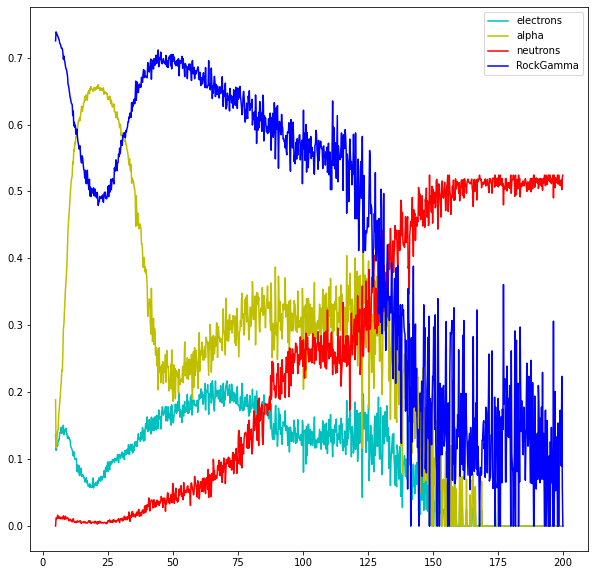

/tmp/ipykernel_3440204/3090546637.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pde_df.drop(pde_df.columns.difference(['Pulse Area','tag']), 1, inplace=True)
100%|██████████████████████████████| 708046/708046 [00:00<00:00, 2297823.68it/s]


In [40]:

EL,Ecentre=PDE(electrons,decay_type)
AL,Acentre=PDE(alphas,decay_type)
NL,Ncentre=PDE(neutron_data,decay_type)
GL,Gcentre=PDE(rockgamma_data,decay_type)
           
l1 = list(map(add, AL, EL))
l2 = list(map(add, NL, GL))

L_total = list(map(add, l1,l2))   
                  
plt.figure(figsize=(10,10))
plt.plot(Ecentre,EL,label='electrons',color='c')
plt.plot(Acentre,AL,label='alpha',color='y')
plt.plot(Ncentre,NL,label='neutrons',color='r')
plt.plot(Gcentre,GL,label='RockGamma',color='b')
#plt.plot(Gcentre,L_total,label='Total',color='black')
plt.legend()
plt.show()

pde_df=decay_type.copy()

pde_df.drop(pde_df.columns.difference(['Pulse Area','tag']), 1, inplace=True)


pde_df['alpha prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Acentre,AL),axis=1),total=708046)
pde_df['electron prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Ecentre,EL),axis=1),total=708046)
pde_df['gamma prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Gcentre,GL),axis=1),total=708046)
pde_df['neutron prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Ncentre,NL),axis=1),total=708046)


one_hot = pd.get_dummies(pde_df['tag'])
pde_df=pd.concat([pde_df, one_hot], axis=1)

In [41]:
pde_df

,Pulse Area,tag,alpha prob,electron prob,gamma prob,neutron prob,RockGamma,alpha,electron,neutron
0,36.003147,electron,0.493637,0.126308,0.636131,0.019423,0,0,1,0
1,6.036995,electron,0.166266,0.127769,0.728308,0.011364,0,0,1,0
2,18.442842,electron,0.656731,0.060621,0.492317,0.004033,0,0,1,0
3,30.409805,electron,0.588057,0.109149,0.569994,0.008889,0,0,1,0
4,107.713371,electron,0.295574,0.125000,0.567134,0.269978,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
708041,19.024788,RockGamma,0.652045,0.064048,0.499389,0.005579,1,0,0,0
708042,7.114547,RockGamma,0.215258,0.147686,0.714214,0.011587,1,0,0,0
708043,25.357714,RockGamma,0.641051,0.095633,0.492135,0.006564,1,0,0,0
708044,6.465114,RockGamma,0.184896,0.139951,0.721435,0.012106,1,0,0,0


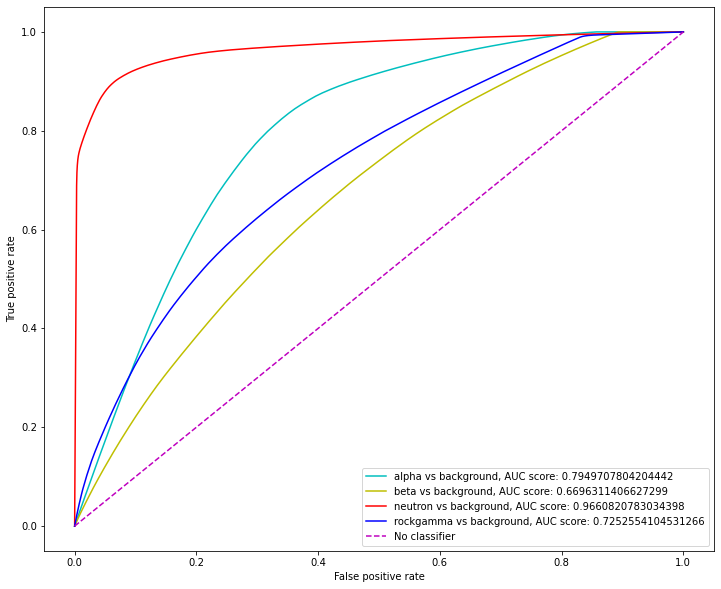

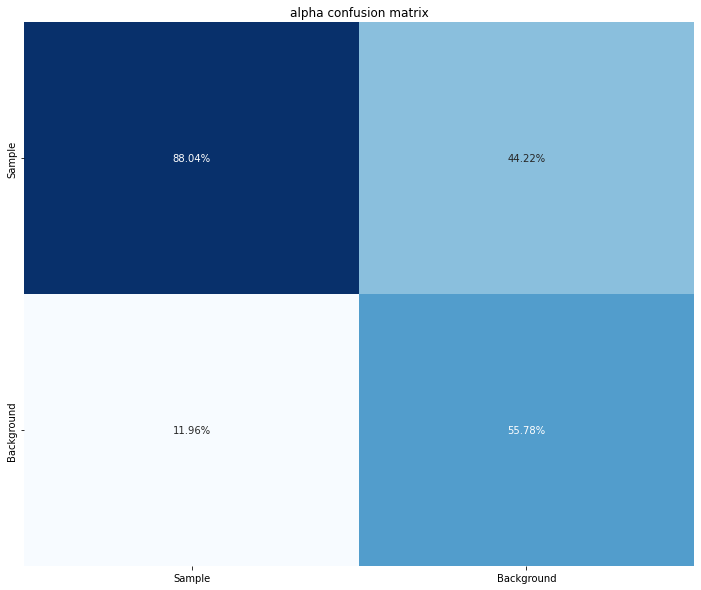

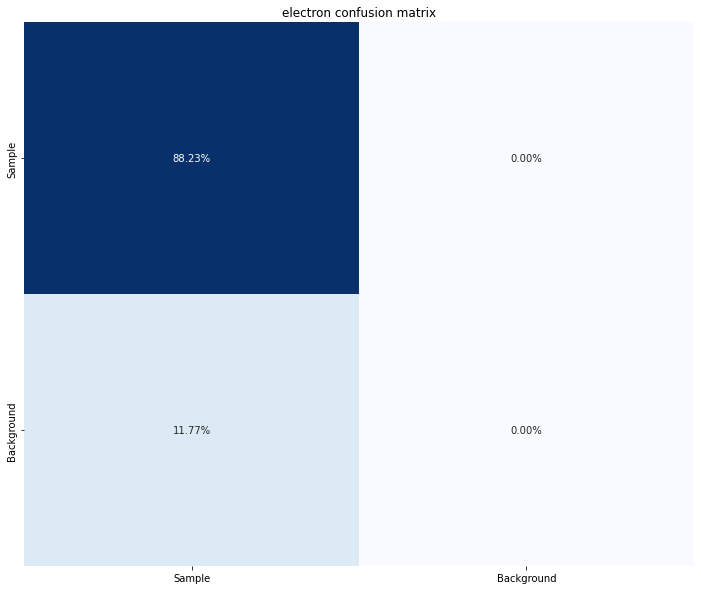

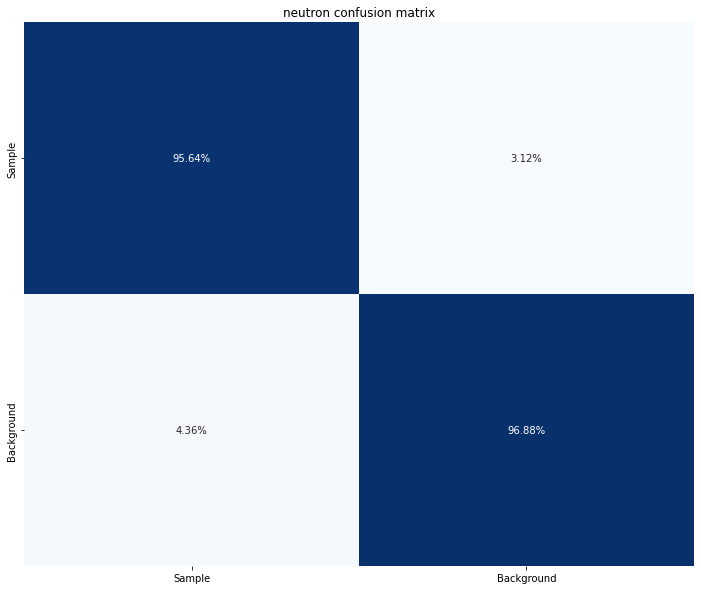

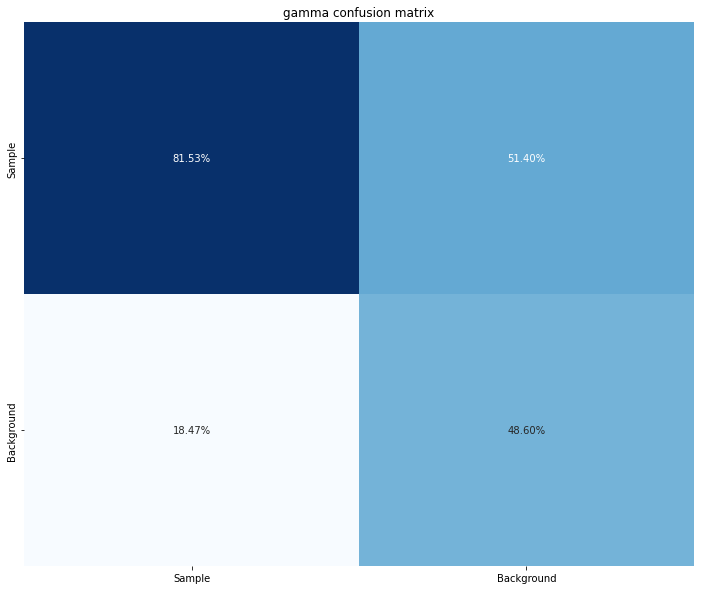

,accuracy,recall,precision,F1 score,specificity,method,sample
0,0.882323,1.000000,0.882323,0.937483,0.000000,Likelyhood,electron
1,0.719114,0.665673,0.880400,0.758125,0.823450,Likelyhood,alpha
2,0.962630,0.968456,0.956411,0.962396,0.956946,Likelyhood,neutron
3,0.650680,0.613355,0.815318,0.700061,0.724653,Likelyhood,gamma


In [59]:


Afpr, Atpr, Athresholds = roc_curve(pde_df['alpha'], pde_df['alpha prob'])
Bfpr, Btpr, Bthresholds = roc_curve(pde_df['electron'], pde_df['electron prob'])
Nfpr, Ntpr, Nthresholds = roc_curve(pde_df['neutron'], pde_df['neutron prob'])
Rfpr, Rtpr, Rthresholds = roc_curve(pde_df['RockGamma'], pde_df['gamma prob'])

plt.rcParams["figure.figsize"] = (12,10)
plt.plot(Afpr,Atpr,label='alpha vs background, AUC score: ' + str(auc(Afpr,Atpr)), color = 'c')
plt.plot(Bfpr,Btpr,label='beta vs background, AUC score: ' + str(auc(Bfpr,Btpr)),color = 'y')
plt.plot(Nfpr,Ntpr,label='neutron vs background, AUC score: ' + str(auc(Nfpr,Ntpr)),color = 'r')
plt.plot(Rfpr,Rtpr,label='rockgamma vs background, AUC score: ' + str(auc(Rfpr,Rtpr)),color = 'b')
plt.plot([0,1],[0,1], linestyle = '--', label = 'No classifier', color = 'm')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

cm_alpha=confusion_matrix(pde_df['alpha'],discriminator(pde_df['alpha prob']),normalize='pred')
categories = ['Sample','Background']
sns.heatmap(cm_alpha,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.title("alpha confusion matrix")
plt.show()

cm_electron=confusion_matrix(pde_df['electron'],discriminator(pde_df['electron prob']),normalize='pred')
sns.heatmap(cm_electron,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.title("electron confusion matrix")
plt.show()

cm_neutron=confusion_matrix(pde_df['neutron'],discriminator(pde_df['neutron prob']),normalize='pred')
sns.heatmap(cm_neutron,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.title("neutron confusion matrix")
plt.show()

cm_gamma=confusion_matrix(pde_df['RockGamma'],discriminator(pde_df['gamma prob']),normalize='pred')
sns.heatmap(cm_gamma,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.title("gamma confusion matrix")
plt.show()


#plt.close()
#plt.figure(figsize=(10,10))
#sns.histplot(data=pde_df, x="alpha prob",hue='tag', element="poly", common_norm=False, stat="density")
#plt.xlabel('Alpha Probability')
#plt.show()
#plt.close()
#plt.figure(figsize=(10,10))
#sns.histplot(data=pde_df, x="electron prob",hue='tag', element="poly", common_norm=False, stat="density")
#plt.xlabel('Electron Probability')
#plt.show()
#plt.close()
#plt.figure(figsize=(10,10))
#sns.histplot(data=pde_df, x="gamma prob",hue='tag', element="poly", common_norm=False, stat="density")
#plt.xlabel('Gamma Probability')
#plt.show()
#plt.close()
#plt.figure(figsize=(10,10))
#sns.histplot(data=pde_df, x="neutron prob",hue='tag', element="poly", common_norm=False, stat="density")
#plt.xlabel('Neutron Probability')
#plt.show()
electron_metrics=confusion_metrics(cm_electron)
alpha_metrics=confusion_metrics(cm_alpha)
neutron_metrics=confusion_metrics(cm_neutron)
gamma_metrics=confusion_metrics(cm_gamma)
columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
pde_metrics=pd.DataFrame([electron_metrics,alpha_metrics,neutron_metrics,gamma_metrics],columns=columns)

pde_metrics['method']='Likelyhood'

pde_metrics['sample']=['electron','alpha','neutron','gamma']
pde_metrics

In [45]:
info_df=(decay_type.iloc[:,0:9]).apply(pd.to_numeric)
info_df=tf.keras.utils.normalize(info_df).squeeze()

electron_df=(electrons.iloc[:,0:9]).apply(pd.to_numeric)
electron_df=tf.keras.utils.normalize(electron_df).squeeze()
electron_df['tag']='electron'
electron_df['tag'] = electron_df['tag'].astype("string")
alpha_df=(alphas.iloc[:,0:9]).apply(pd.to_numeric)
alpha_df=tf.keras.utils.normalize(alpha_df).squeeze()
alpha_df['tag']='alpha'
alpha_df['tag'] = alpha_df['tag'].astype("string")
neutron_df=(neutron_data.iloc[:,0:9]).apply(pd.to_numeric)
neutron_df=tf.keras.utils.normalize(neutron_df).squeeze()
neutron_df['tag']='neutron'
neutron_df['tag'] = neutron_df['tag'].astype("string")
gamma_df=(rockgamma_data.iloc[:,0:9]).apply(pd.to_numeric)
gamma_df=tf.keras.utils.normalize(gamma_df).squeeze()
gamma_df['tag']='gamma'
gamma_df['tag'] = gamma_df['tag'].astype("string")
decay_df=pd.concat([electron_df,alpha_df,neutron_df,gamma_df],ignore_index=True)



plt.figure(figsize=(10,10))
sns.boxplot(data=info_df)
plt.show()



#plt.figure(figsize=(10,10))
#sns.set_style('whitegrid')
#sns.violinplot(x='tag',y='Pulse Area',data=chains)
#plt.show()

#plt.close()
#sns.set_style('whitegrid')
#sns.pairplot(decay_type,kind="scatter", hue='tag', height=3,    
#    x_vars=["Pulse Area", "Coincidence","Peak Time","time/area"],
#    y_vars=["Pulse Area", "Coincidence","Peak Time",'time/area'],
#    plot_kws=dict(s=80, edgecolor="white", linewidth=2.5, alpha=0.3)
#)
#plt.show()

KeyboardInterrupt: 

In [15]:
#plot(electrons,alphas,neutron_data,rockgamma_data,decay_type,'electrons','alphas','neutrons','RockGamma')
#guess_data,guess_frames,guess_info=cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_rockgamma,Data_notag,Data_withtag)
#metrics,data,info=auto_cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_withtag)
metrics,cut_df,info=auto_cut(electrons,alphas,neutron_data,rockgamma_data,decay_type,'electron','alpha','neutron','RockGamma')

100%|█████████████████████████████████████████| 100/100 [29:13<00:00, 17.54s/it]
IOStream.flush timed out
100%|█████████████████████████████████████████| 100/100 [30:54<00:00, 18.54s/it]
IOStream.flush timed out
100%|█████████████████████████████████████████| 100/100 [29:04<00:00, 17.45s/it]
IOStream.flush timed out
100%|█████████████████████████████████████████| 100/100 [30:06<00:00, 18.06s/it]


      sample  accuracy    recall  precision  F1 score  specificity
0   electron  0.730469  0.408817   0.193931  0.263069     0.773369
1      alpha  0.709712  0.842057   0.552541  0.667247     0.639807
2    neutron  0.961802  0.757638   0.935740  0.837323     0.992242
3  RockGamma  0.504559  0.986919   0.450372  0.618497     0.173590


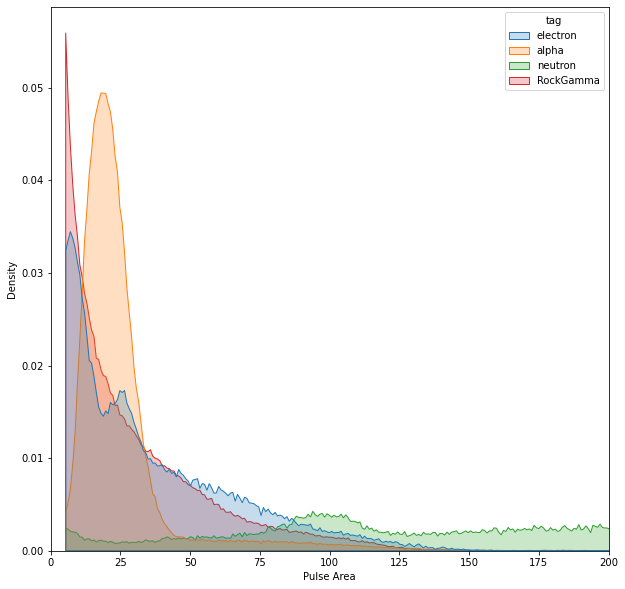

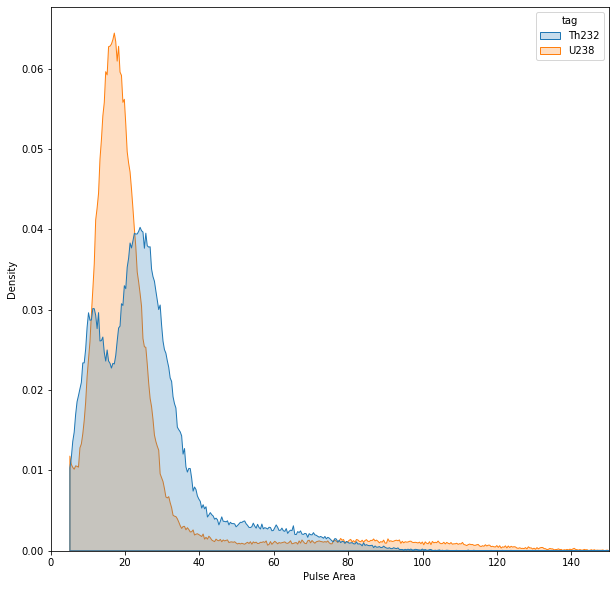

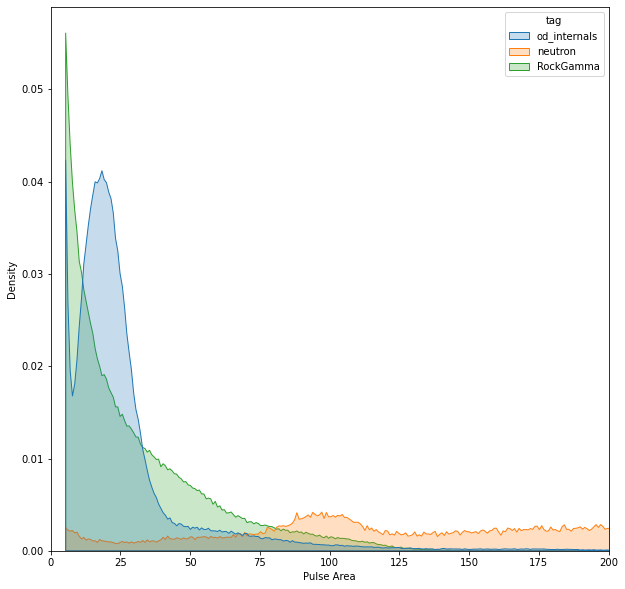

In [16]:
chains=pd.concat([Th232_chain,U238_chain],ignore_index=True)

plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=decay_type, x="Pulse Area",hue='tag', element="poly", common_norm=False, stat="density")
plt.xlim(0, 200)
plt.show()
plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=chains, x="Pulse Area",hue='tag', element="poly", common_norm=False, stat="density")
plt.xlim(0, 150)
plt.show()
internals=internals_data
internals['tag']='od_internals'
original_data=pd.concat([internals,neutron_data,rockgamma_data],ignore_index=True)
plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=original_data, x="Pulse Area",hue='tag', element="poly", common_norm=False, stat="density")
plt.xlim(0, 200)
plt.show()



In [32]:
data1=(pd.DataFrame(cut_df[0]))
data1['cut tag']='electrons'

data2=(pd.DataFrame(cut_df[1]))
data2['cut tag']='alpha'

data3=(pd.DataFrame(cut_df[2]))
data3['cut tag']='neutron'

data4=(pd.DataFrame(cut_df[3]))
data4['cut tag']='RockGamma'

cut_df=pd.concat([data1,data2,data3,data4],ignore_index=True)

metrics['method']='cut'

plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=cut_df, x="Pulse Area",hue='tag', element="poly", common_norm=False, stat="density")
plt.xlim(0,500)
plt.show()


label_true =pd.get_dummies(data = cut_df['tag'])

label_pred =pd.get_dummies(data = cut_df['cut tag'])
cm=confusion_matrix(np.asarray(label_true).argmax(axis=1), np.asarray(label_pred).argmax(axis=1),normalize='pred')

categories = ['electrons','alpha','RockGamma','neutron']

sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()


KeyError: 0

In [33]:
chains=pd.concat([Th232_chain,U238_chain],ignore_index=True)
history,labels_test,proba=binary_run(chains,"Th232","U238")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 18)                180       
                                                                 
 dense_2 (Dense)             (None, 36)                684       
                                                                 
 dense_3 (Dense)             (None, 18)                666       
                                                                 
 dense_4 (Dense)             (None, 18)                342       
                                                                 
 dense_5 (Dense)             (None, 1)                 19        
                                                                 
Total params: 1,981
Trainable params: 1,981
Non-trainabl

2022-03-28 14:16:29.351024: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


155/155 [==============================] - 1s 4ms/step - loss: 0.6727 - auc: 0.6063 - binary_accuracy: 0.5749 - val_loss: 0.6420 - val_auc: 0.6787 - val_binary_accuracy: 0.6277
Epoch 2/400
155/155 [==============================] - 0s 2ms/step - loss: 0.6392 - auc: 0.6814 - binary_accuracy: 0.6380 - val_loss: 0.6359 - val_auc: 0.6903 - val_binary_accuracy: 0.6430
Epoch 3/400
155/155 [==============================] - 0s 2ms/step - loss: 0.6349 - auc: 0.6894 - binary_accuracy: 0.6436 - val_loss: 0.6360 - val_auc: 0.6876 - val_binary_accuracy: 0.6431
Epoch 4/400
155/155 [==============================] - 0s 2ms/step - loss: 0.6343 - auc: 0.6896 - binary_accuracy: 0.6438 - val_loss: 0.6328 - val_auc: 0.6935 - val_binary_accuracy: 0.6475
Epoch 5/400
155/155 [==============================] - 0s 2ms/step - loss: 0.6331 - auc: 0.6921 - binary_accuracy: 0.6452 - val_loss: 0.6293 - val_auc: 0.6979 - val_binary_accuracy: 0.6490
Epoch 6/400
155/155 [==============================] - 0s 2ms/step 

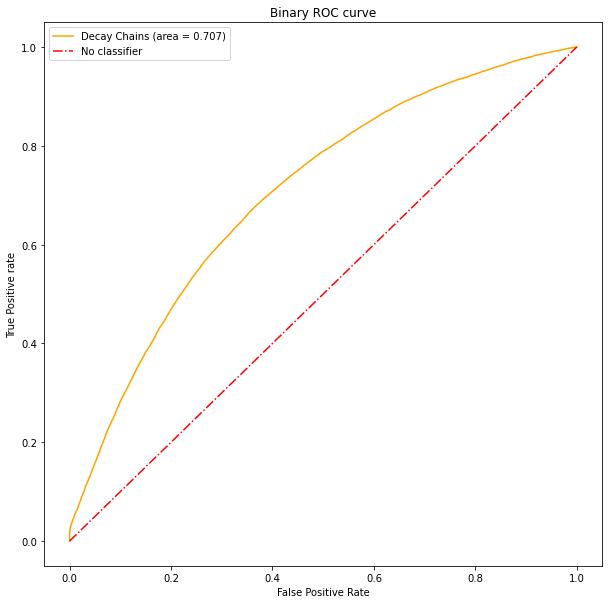

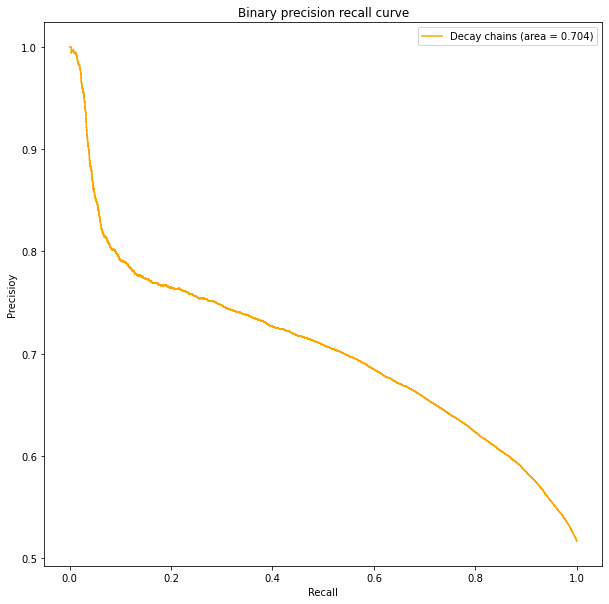

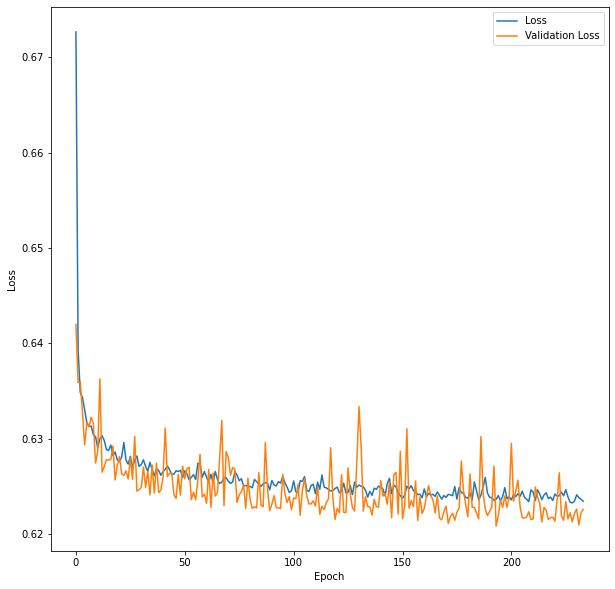

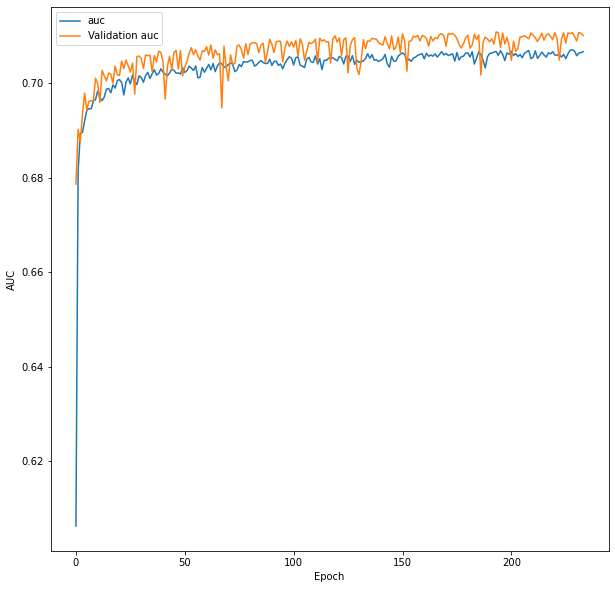

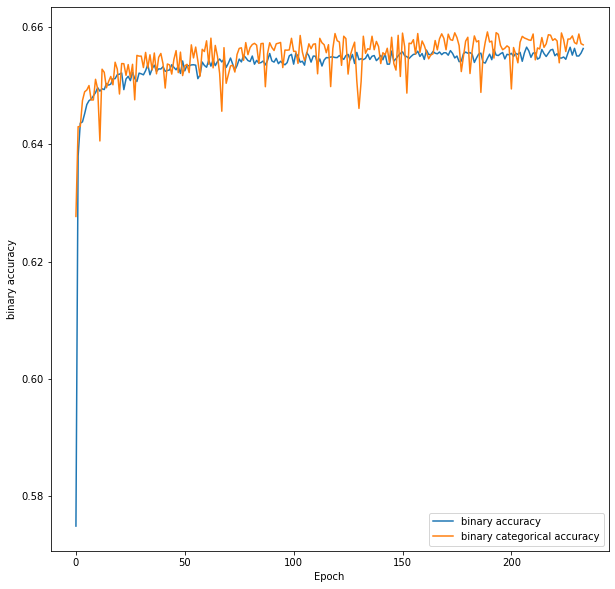

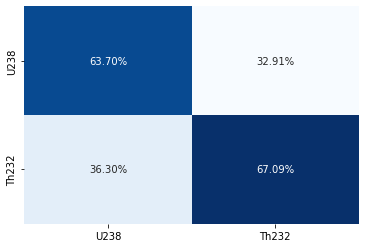

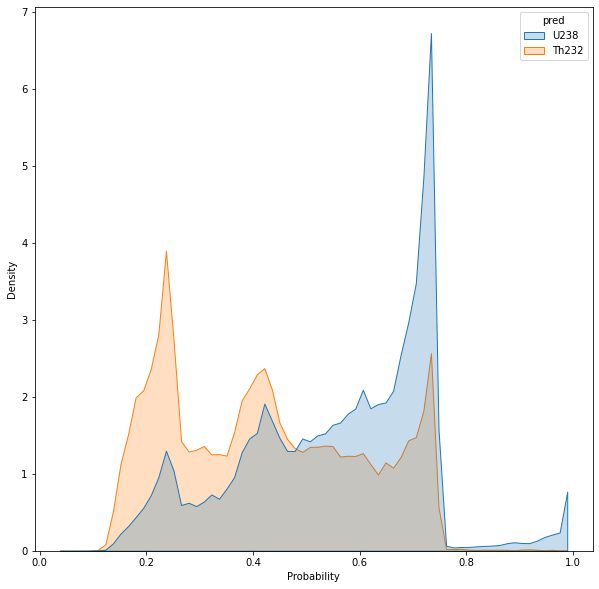

In [48]:

   
fpr, tpr, thresh = roc_curve(labels_test, proba, pos_label=1)
prec, recall,recall_thresh = precision_recall_curve(labels_test, proba, pos_label=1)
predictions = discriminator(proba)
confusion=confusion_matrix(labels_test, predictions)

F1=(2*recall*prec)/(recall+prec)



plt.close()
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr,color='orange', label='Decay Chains (area = {:.3f})'.format(auc(fpr,tpr)))
plt.plot([0, 1], [0, 1],linestyle='dashdot',color='red', label='No classifier')
plt.title('Binary ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(recall, prec,color='orange', label='Decay chains (area = {:.3f})'.format(auc(recall,prec)))
plt.title('Binary precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precisioy')
plt.legend(loc='best')
plt.show()



plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['auc'],label='auc')
plt.plot(history.history['val_auc'],label='Validation auc')

plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['binary_accuracy'],label='binary accuracy')
plt.plot(history.history['val_binary_accuracy'],label='binary categorical accuracy')

plt.xlabel('Epoch')
plt.ylabel('binary accuracy')
plt.legend()
plt.show()

cm=confusion_matrix(labels_test,discriminator(proba),normalize='pred')

categories = ['U238','Th232']
#cmn=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()


prob_col=['prob','true']

chains_data=pd.DataFrame([],columns=prob_col)
chains_data['prob']=proba.tolist()
chains_data['true']=labels_test.tolist()
chains_data=chains_data.explode(column=prob_col)
chains_data.loc[chains_data['true'] ==1, 'pred'] = 'U238'
chains_data.loc[chains_data['true'] ==0, 'pred'] = 'Th232'

plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=chains_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
plt.xlabel('Probability')
plt.show()


In [60]:
history, labels_test,proba=multiclass(decay_type)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 9)                 90        
                                                                 
 dense_7 (Dense)             (None, 18)                180       
                                                                 
 dense_8 (Dense)             (None, 36)                684       
                                                                 
 dense_9 (Dense)             (None, 18)                666       
                                                                 
 dense_10 (Dense)            (None, 18)                342       
                                                                 
 dense_11 (Dense)            (None, 4)                 76        
                                                                 
Total params: 2,038
Trainable params: 2,038
Non-traina

/tmp/ipykernel_3440204/3970830169.py:18: RuntimeWarning: invalid value encountered in true_divide
  F1[i]=(2*recall[i]*prec[i])/(recall[i]+prec[i])


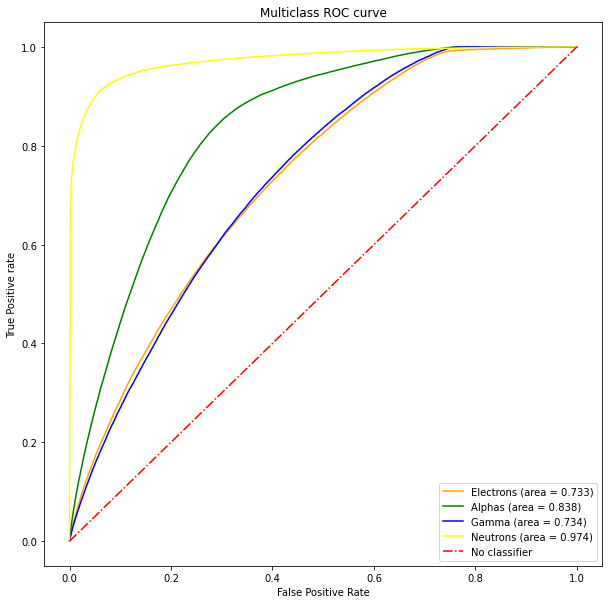

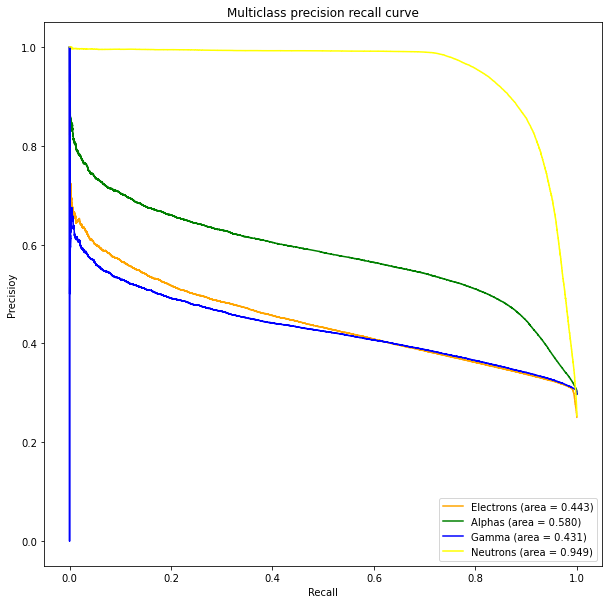

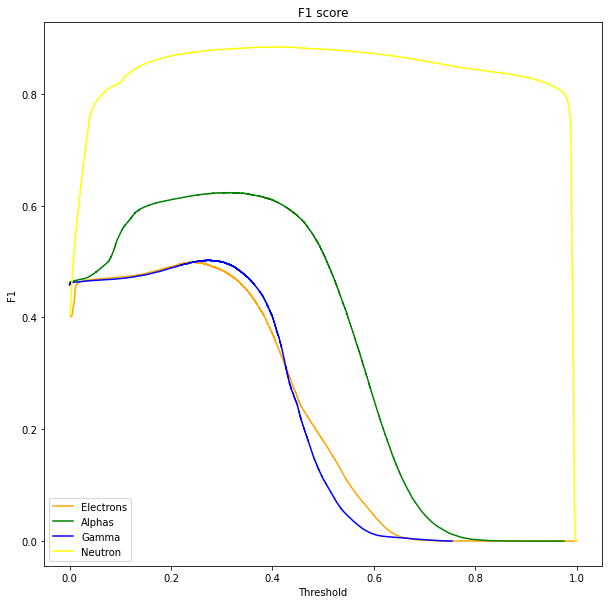

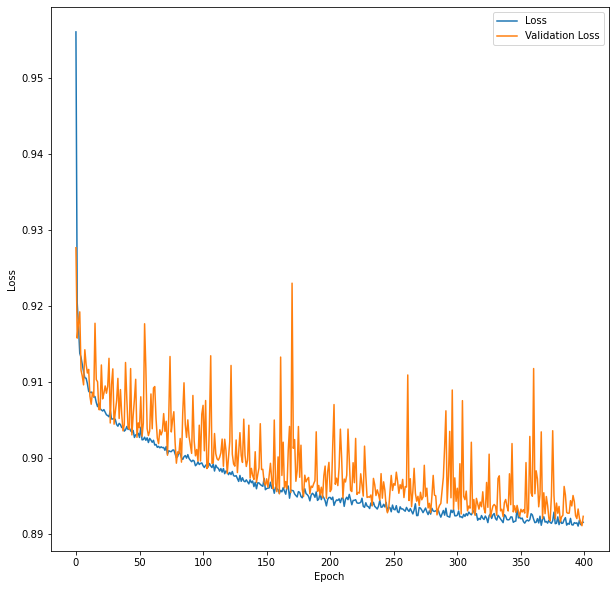

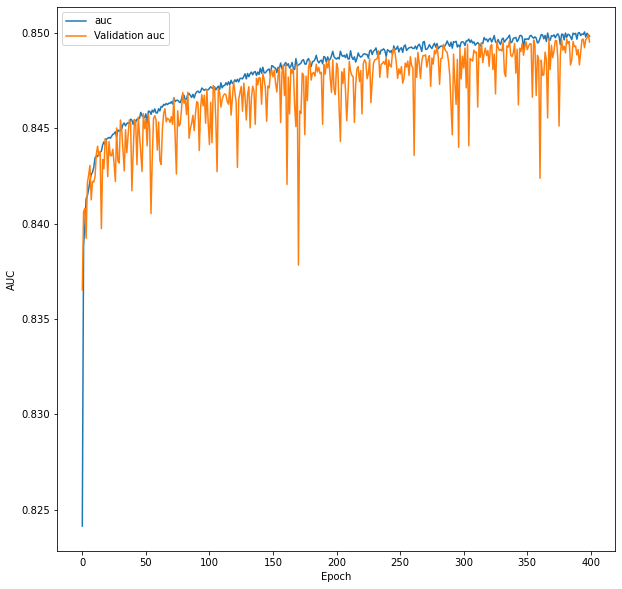

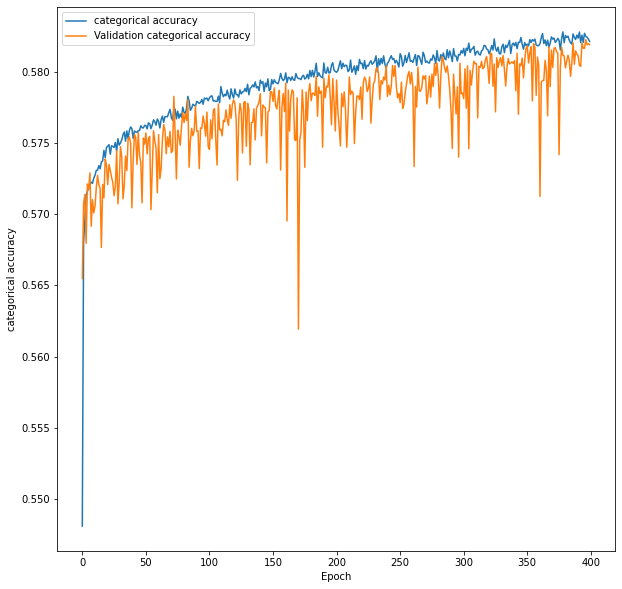

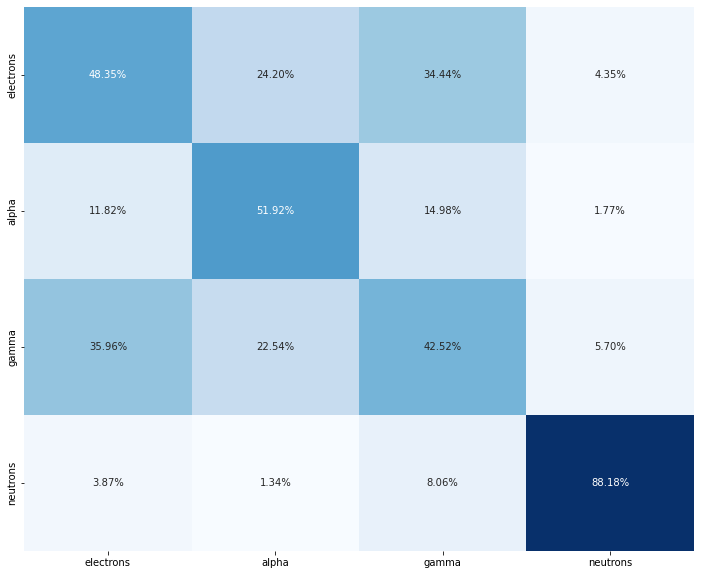

In [62]:
fpr = {}
tpr = {}
thresh ={}
prec={}
recall={}
recall_thresh={}
confusion_list=[]
NN_metrics_list=[]
F1={}
n_class = 4
sample=["electron","alpha",'Gamma','neutron']
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_test[:,i], proba[:,i], pos_label=1)
    prec[i], recall[i],recall_thresh[i] = precision_recall_curve(labels_test[:,i], proba[:,i], pos_label=1)
    predictions = discriminator(proba[:,i])
    confusion=confusion_matrix(labels_test[:,i], predictions)
    NN_metrics_list.append(confusion_metrics(confusion))
    F1[i]=(2*recall[i]*prec[i])/(recall[i]+prec[i])

F1[0]=F1[0][:-1]
F1[1]=F1[1][:-1]
F1[2]=F1[2][:-1]
F1[3]=F1[3][:-1]
plt.close()
plt.figure(figsize=(10,10))
plt.plot(fpr[0], tpr[0],color='orange', label='Electrons (area = {:.3f})'.format(auc(fpr[0],tpr[0])))
plt.plot(fpr[1], tpr[1],color='green', label='Alphas (area = {:.3f})'.format(auc(fpr[1],tpr[1])))
plt.plot(fpr[2], tpr[2],color='blue', label='Gamma (area = {:.3f})'.format(auc(fpr[2],tpr[2])))
plt.plot(fpr[3], tpr[3],color='yellow', label='Neutrons (area = {:.3f})'.format(auc(fpr[3],tpr[3])))
plt.plot([0, 1], [0, 1],linestyle='dashdot',color='red', label='No classifier')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(recall[0], prec[0],color='orange', label='Electrons (area = {:.3f})'.format(auc(recall[0],prec[0])))
plt.plot(recall[1], prec[1],color='green', label='Alphas (area = {:.3f})'.format(auc(recall[1],prec[1])))
plt.plot(recall[2], prec[2],color='blue', label='Gamma (area = {:.3f})'.format(auc(recall[2],prec[2])))
plt.plot(recall[3], prec[3],color='yellow', label='Neutrons (area = {:.3f})'.format(auc(recall[3],prec[3])))
plt.title('Multiclass precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precisioy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(recall_thresh[0], F1[0],color='orange', label='Electrons')
plt.plot(recall_thresh[1], F1[1],color='green', label='Alphas')
plt.plot(recall_thresh[2], F1[2],color='blue', label='Gamma')
plt.plot(recall_thresh[3], F1[3],color='yellow', label='Neutron')
plt.title('F1 score')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['auc'],label='auc')
plt.plot(history.history['val_auc'],label='Validation auc')

plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['categorical_accuracy'],label='categorical accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation categorical accuracy')

plt.xlabel('Epoch')
plt.ylabel('categorical accuracy')
plt.legend()
plt.show()


cm=confusion_matrix(np.asarray(labels_test).argmax(axis=1), np.asarray(proba).argmax(axis=1),normalize='pred')

categories = ['electrons','alpha','gamma','neutrons']
#cmn=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()


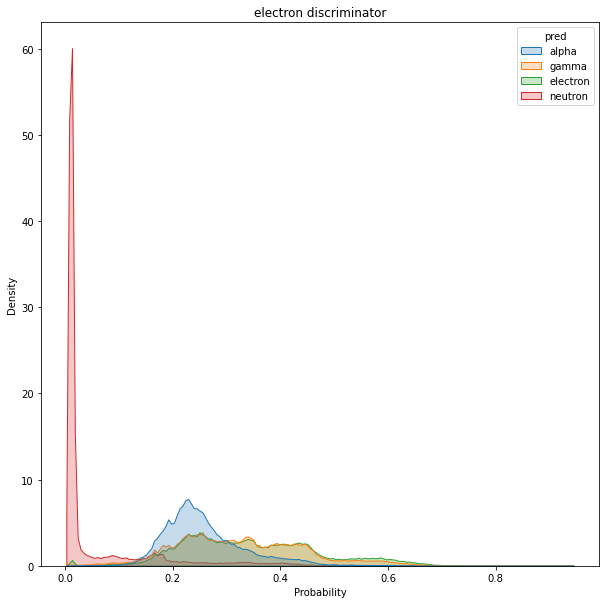

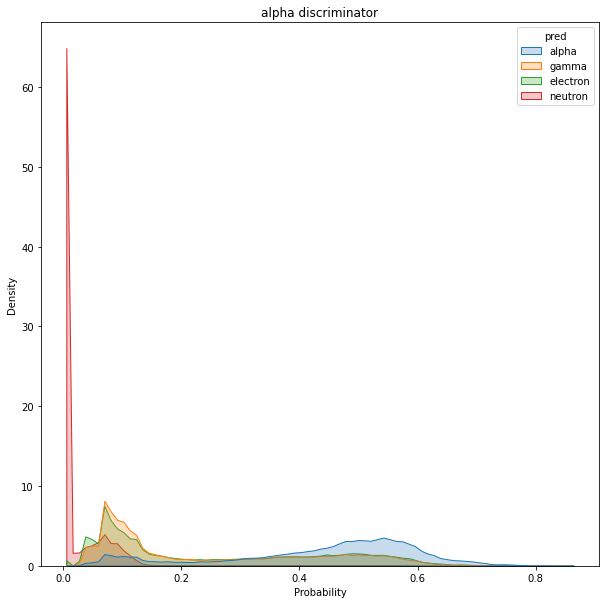

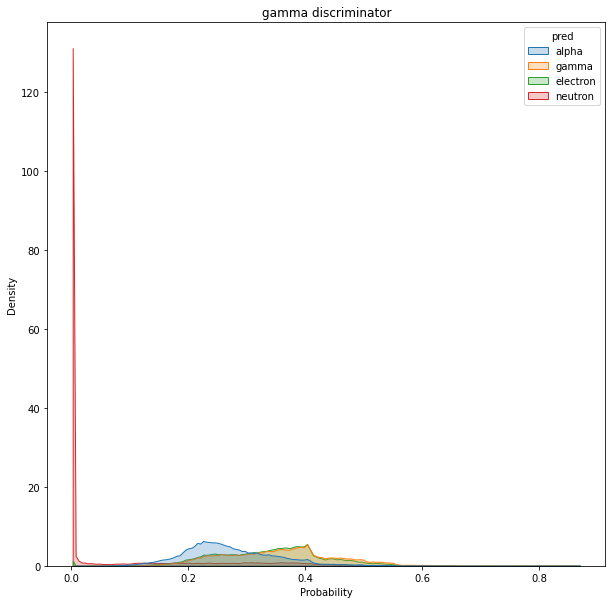

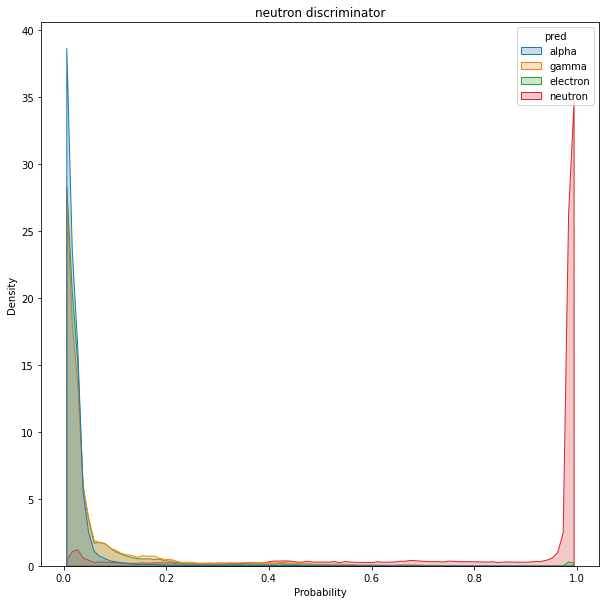

In [19]:
prob_col=['prob','electron_true','alpha_true','gamma_true','neutron_true']


electron_data=pd.DataFrame([],columns=prob_col)
electron_data['prob']=(proba[:,0])
electron_data['electron_true']=(labels_test[:,0])
electron_data['alpha_true']=(labels_test[:,1])
electron_data['gamma_true']=(labels_test[:,2])
electron_data['neutron_true']=(labels_test[:,3])
electron_data.loc[electron_data['electron_true'] ==1, 'pred'] = 'electron'
electron_data.loc[electron_data['alpha_true'] ==1, 'pred'] = 'alpha'
electron_data.loc[electron_data['gamma_true'] ==1, 'pred'] = 'gamma'
electron_data.loc[electron_data['neutron_true'] ==1, 'pred'] = 'neutron'


alpha_data=pd.DataFrame([],columns=prob_col)
alpha_data['prob']=(proba[:,1])
alpha_data['electron_true']=(labels_test[:,0])
alpha_data['alpha_true']=(labels_test[:,1])
alpha_data['gamma_true']=(labels_test[:,2])
alpha_data['neutron_true']=(labels_test[:,3])
alpha_data.loc[alpha_data['electron_true'] ==1, 'pred'] = 'electron'
alpha_data.loc[alpha_data['alpha_true'] ==1, 'pred'] = 'alpha'
alpha_data.loc[alpha_data['gamma_true'] ==1, 'pred'] = 'gamma'
alpha_data.loc[alpha_data['neutron_true'] ==1, 'pred'] = 'neutron'

gamma_data=pd.DataFrame([],columns=prob_col)
gamma_data['prob']=(proba[:,2])
gamma_data['electron_true']=(labels_test[:,0])
gamma_data['alpha_true']=(labels_test[:,1])
gamma_data['gamma_true']=(labels_test[:,2])
gamma_data['neutron_true']=(labels_test[:,3])
gamma_data.loc[gamma_data['electron_true'] ==1, 'pred'] = 'electron'
gamma_data.loc[gamma_data['alpha_true'] ==1, 'pred'] = 'alpha'
gamma_data.loc[gamma_data['gamma_true'] ==1, 'pred'] = 'gamma'
gamma_data.loc[gamma_data['neutron_true'] ==1, 'pred'] = 'neutron'

neutron_data=pd.DataFrame([],columns=prob_col)
neutron_data['prob']=(proba[:,3])
neutron_data['electron_true']=(labels_test[:,0])
neutron_data['alpha_true']=(labels_test[:,1])
neutron_data['gamma_true']=(labels_test[:,2])
neutron_data['neutron_true']=(labels_test[:,3])
neutron_data.loc[neutron_data['electron_true'] ==1, 'pred'] = 'electron'
neutron_data.loc[neutron_data['alpha_true'] ==1, 'pred'] = 'alpha'
neutron_data.loc[neutron_data['gamma_true'] ==1, 'pred'] = 'gamma'
neutron_data.loc[neutron_data['neutron_true'] ==1, 'pred'] = 'neutron'




plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=electron_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
plt.xlabel('Probability')
plt.title('electron discriminator')
plt.show()
plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=alpha_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
plt.xlabel('Probability')
plt.title('alpha discriminator')
plt.show()
plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=gamma_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
plt.xlabel('Probability')
plt.title('gamma discriminator')
plt.show()
plt.close()
plt.figure(figsize=(10,10))
sns.histplot(data=neutron_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
plt.xlabel('Probability')
plt.title('neutron discriminator')
plt.show()

In [64]:
columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
NN_metrics=pd.DataFrame(np.asarray(NN_metrics_list),columns=columns)
NN_metrics=NN_metrics.round(decimals = 5)
NN_metrics['method']='multiclassifier'
NN_metrics['sample']=['electron','alpha','neutron','gamma']

comparison_metrics=pd.concat([NN_metrics,pde_metrics])
comparison_metrics

,accuracy,recall,precision,F1 score,specificity,method,sample
0,0.755720,0.972480,0.765230,0.856500,0.106730,multiclassifier,electron
1,0.785910,0.896420,0.831390,0.862680,0.454090,multiclassifier,alpha
2,0.753760,0.983330,0.759570,0.857090,0.061800,multiclassifier,neutron
3,0.943140,0.981570,0.944710,0.962790,0.828290,multiclassifier,gamma
0,0.882323,1.000000,0.882323,0.937483,0.000000,Likelyhood,electron
1,0.719114,0.665673,0.880400,0.758125,0.823450,Likelyhood,alpha
2,0.962630,0.968456,0.956411,0.962396,0.956946,Likelyhood,neutron
3,0.650680,0.613355,0.815318,0.700061,0.724653,Likelyhood,gamma


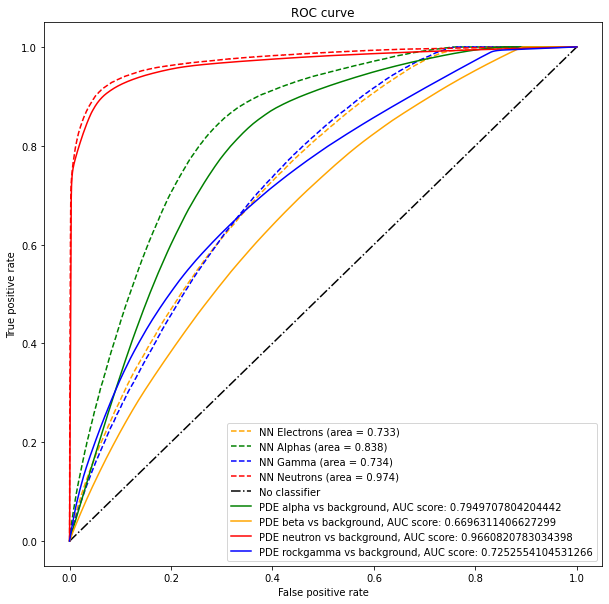

In [66]:
#electron_data=info[0]
#alpha_data=info[1]
#neutron_data=info[2]
#gamma_data=info[3]

#electron_max=electron_data[electron_data['F1 score'] == electron_data['F1 score'].max()]
#electron_metrics=electron_data[electron_data['minval']== 0]
#auc_electron=auc(1-electron_metrics['specificity'], electron_metrics['recall'])
#pr_auc_electron=auc(electron_metrics['precision'], electron_metrics['recall'])

#alpha_max=alpha_data[alpha_data['F1 score'] == alpha_data['F1 score'].max()]
#alpha_metrics=alpha_data[alpha_data['minval']== 0]
#auc_alpha=auc(1-alpha_metrics['specificity'], alpha_metrics['recall'])
#pr_auc_alpha=auc(alpha_metrics['precision'], alpha_metrics['recall'])


#neutron_max=neutron_data[neutron_data['F1 score'] == neutron_data['F1 score'].max()]
#neutron_metrics=neutron_data[neutron_data['minval']== 0]
#auc_neutron=auc(1-neutron_metrics['specificity'], neutron_metrics['recall'])
#pr_auc_neutron=auc(neutron_metrics['precision'], neutron_metrics['recall'])

#gamma_max=gamma_data[gamma_data['F1 score'] == gamma_data['F1 score'].max()]
#gamma_metrics=gamma_data[gamma_data['minval']== 0]
#auc_gamma=auc(1-gamma_metrics['specificity'], gamma_metrics['recall'])
#pr_auc_gamma=auc(gamma_metrics['precision'], gamma_metrics['recall'])



plt.figure(figsize=(10,10))

plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='NN Electrons (area = {:.3f})'.format(auc(fpr[0],tpr[0])))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='NN Alphas (area = {:.3f})'.format(auc(fpr[1],tpr[1])))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='NN Gamma (area = {:.3f})'.format(auc(fpr[2],tpr[2])))
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='NN Neutrons (area = {:.3f})'.format(auc(fpr[3],tpr[3])))
plt.plot([0, 1], [0, 1],linestyle='dashdot',color='black', label='No classifier')
plt.plot(Afpr,Atpr,label='PDE alpha vs background, AUC score: ' + str(auc(Afpr,Atpr)), color = 'green')
plt.plot(Bfpr,Btpr,label='PDE beta vs background, AUC score: ' + str(auc(Bfpr,Btpr)),color = 'orange')
plt.plot(Nfpr,Ntpr,label='PDE neutron vs background, AUC score: ' + str(auc(Nfpr,Ntpr)),color = 'red')
plt.plot(Rfpr,Rtpr,label='PDE rockgamma vs background, AUC score: ' + str(auc(Rfpr,Rtpr)),color = 'blue')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()





NameError: name 'pr_metrics_po212_na22' is not defined

<Figure size 720x720 with 0 Axes>

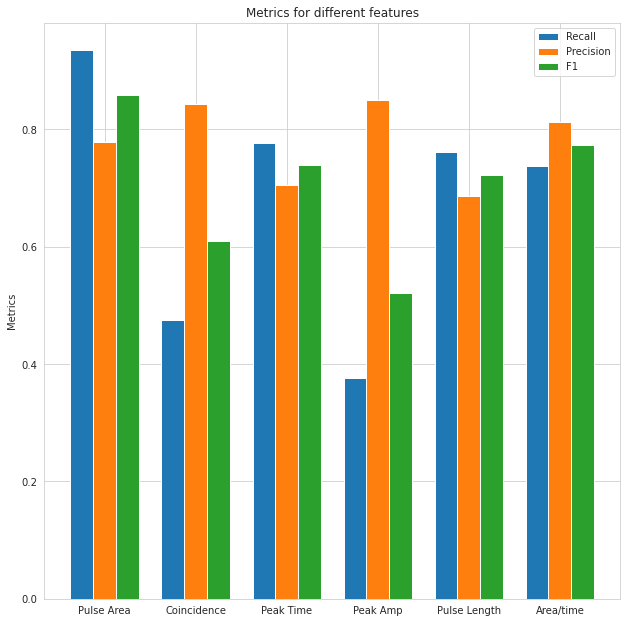

In [35]:
labels=['Pulse Area', 'Coincidence', 'Peak Time', 'Peak Amp', 'Pulse Length', 'Area/time']
accuracy=[0.915,0.842,0.859,0.822,0.845,0.889]
recall=[0.935,0.476,0.777,0.376,0.762,0.738]
precision=[0.778,0.844,0.705,0.851,0.687,0.812]
F1=[0.858,0.609,0.739,0.521,0.722,0.774]
specificity=[0.907,0.969,0.887,0.977,0.880,0.941]


width = 0.35 

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)
ax.bar(X-0.25, recall, width = 0.25,label="Recall")
ax.bar(X , precision, width = 0.25,label="Precision")
ax.bar(X + 0.25, F1, width = 0.25,label="F1")
ticks=[0,1,2,3,4,5]
ax.set_xticks(ticks, labels)
ax.set_ylabel('Metrics')
ax.set_title('Metrics for different features')



plt.legend(loc='best')
plt.show()